# Curriculum Learning with SuperLoss (Tensorflow Backend)
In this example, we are going to demonstrate how to easily add curriculum learning to any project using SuperLoss (paper available [here](https://papers.nips.cc/paper/2020/file/2cfa8f9e50e0f510ede9d12338a5f564-Paper.pdf)). When humans learn something in school, we are first taught how to do easy versions of the task before graduating to more difficult problems. Curriculum learning seeks to emulate that process with neural networks. One way to do this would be to try and modify a data pipeline to change the order in which it presents examples, but an easier way is to simply modify your loss term to reduce the contribution of difficult examples until later on during training. Curriculum learning has been shown to be especially useful when you have label noise in your dataset, since noisy samples are essentially 'hard' and you want to put off trying to learn them. 

## Import the required libraries

In [1]:
import math
import tempfile

import numpy as np
from tensorflow.python.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.python.keras.models import Sequential

import fastestimator as fe
from fastestimator.dataset.data import cifair100
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop
from fastestimator.op.numpyop.univariate import CoarseDropout, Normalize
from fastestimator.op.tensorop.loss import CrossEntropy, SuperLoss
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import MCC
from fastestimator.trace.xai import LabelTracker

In [2]:
#training parameters
epochs = 50
batch_size = 128
max_train_steps_per_epoch = None
max_eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

## Step 1 - Data preparation

In this step, we will load the [ciFAIR100](https://arxiv.org/pdf/1902.00423.pdf) training and validation datasets. We use a FastEstimator API to load the dataset and then get a test set by splitting 50% of the data off of the evaluation set. We are also going to corrupt the training data by adding 40% label noise, to simulate the fact that many real-world datasets may have low quality annotations.

In [3]:
from fastestimator.dataset.data import cifair100

train_data, eval_data = cifair100.load_data()
test_data = eval_data.split(0.5)

def corrupt_dataset(dataset, n_classes=100, corruption_fraction=0.4):
    # Keep track of which samples were corrupted for visualization later
    corrupted = [0 for _ in range(len(dataset))]
    # Perform the actual label corruption
    n_samples_per_class = len(dataset) // n_classes
    n_to_corrupt_per_class = math.floor(corruption_fraction * n_samples_per_class)
    n_corrupted = [0] * n_classes
    i = 0
    while any([elem < n_to_corrupt_per_class for elem in n_corrupted]):
        current_class = dataset[i]['y'].item()
        if n_corrupted[current_class] < n_to_corrupt_per_class:
            dataset[i]['y'] = (dataset[i]['y'] + np.random.randint(1, n_classes)) % n_classes
            n_corrupted[current_class] += 1
            corrupted[i] = 1
        i += 1
    # Put the corruption labels into the dataset for visualization
    dataset['data_labels'] = np.array(corrupted, dtype=np.int).reshape((len(dataset), 1))

corrupt_dataset(train_data)

## Step 2 - Build some Estimators

We will define a function that builds relatively simple estimators given only a particular loss function as an input. We can then compare the effects of using a regular loss versus a SuperLoss on our artificially corrupted dataset.

In [4]:
def big_lenet(classes=100, input_shape=(32, 32, 3)):
    # Like a LeNet model, but bigger. 
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='swish', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='swish'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='swish'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='swish'))
    model.add(BatchNormalization())
    model.add(Dense(classes, activation='softmax'))
    return model

def build_estimator(loss_op):
    pipeline = fe.Pipeline(train_data=train_data,
                           eval_data=eval_data,
                           test_data=test_data,
                           batch_size=batch_size,
                           ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
                                PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
                                RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
                                Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
                                CoarseDropout(inputs="x", outputs="x", max_holes=1, mode="train"),
                                ])
    model = fe.build(model_fn=big_lenet, optimizer_fn='adam')
    network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        loss_op,  # <<<----------------------------- This is where the secret sauce will go
        UpdateOp(model=model, loss_name="ce")
    ])
    traces = [
        MCC(true_key="y", pred_key="y_pred"),
        BestModelSaver(model=model, save_dir=save_dir, metric="mcc", save_best_mode="max", load_best_final=True),
        # We will also visualize the difference between the normal and corrupted image confidence scores. You could follow this with an
        # ImageViewer trace, but we will get the data out of the system summary instead later for viewing.
        LabelTracker(metric="confidence", label="data_labels", label_mapping={"Normal": 0, "Corrupted": 1}, mode="train", outputs="label_confidence"),
    ]
    estimator = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=epochs,
                             traces=traces,
                             max_train_steps_per_epoch=max_train_steps_per_epoch,
                             max_eval_steps_per_epoch=max_eval_steps_per_epoch,
                             log_steps=300)
    return estimator

## Step 3 - Train a baseline model with a regular loss

Let's start by training a regular model using standard CrossEntropy and see what we get. We will also define a fake SuperLoss wrapper to get sample confidence estimates in order to visualize the differences between clean and corrupted data performance.

In [5]:
class FakeSuperLoss(SuperLoss):
    def forward(self, data, state):
        superloss, confidence = super().forward(data, state)
        regularloss = fe.backend.reduce_mean(self.loss.forward(data, state))
        return [regularloss, confidence]

loss = FakeSuperLoss(CrossEntropy(inputs=("y_pred", "y"), outputs="ce"), output_confidence="confidence")
estimator_regular = build_estimator(loss)
regular = estimator_regular.fit("RegularLoss")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: 5.2058554;
FastEstimator-Train: step: 300; ce: 4.219718; steps/sec: 10.95;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 38.74 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmp8r026lm8/model_best_mcc.h5
FastEstimator-Eval: step: 391; epoch: 1; ce: 3.9026656; max_mcc: 0.12934212333991163; mcc: 0.12934212333991163; since_best_mcc: 0;
FastEstimator-Train: step: 600; ce: 4.3571787; steps/sec: 11.08;

## Step 4 - Train a model using SuperLoss

Now it's time to try using SuperLoss to see whether curriculum learning can help us overcome our label noise. Note how easy it is to add SuperLoss to any existing loss function:

In [6]:
loss = SuperLoss(CrossEntropy(inputs=("y_pred", "y"), outputs="ce"), output_confidence="confidence")  # The output_confidence arg is only needed if you want to visualize
estimator_super = build_estimator(loss)
superL = estimator_super.fit("SuperLoss")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: -0.37075347;
FastEstimator-Train: step: 300; ce: -0.8623735; steps/sec: 11.54;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 37.39 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmp8r026lm8/model1_best_mcc.h5
FastEstimator-Eval: step: 391; epoch: 1; ce: -0.7983143; max_mcc: 0.1125597474520802; mcc: 0.1125597474520802; since_best_mcc: 0;
FastEstimator-Train: step: 600; ce: -1.2613001; steps/sec: 1

## Step 5 - Performance Comparison

Let's take a look at how each of the final models compare:

In [7]:
estimator_regular.test()

FastEstimator-Test: step: 19550; epoch: 50; ce: 2.54847; mcc: 0.40158894368465714;


In [8]:
estimator_super.test()

FastEstimator-Test: step: 19550; epoch: 50; ce: -1.2840478; mcc: 0.4381719790823748;


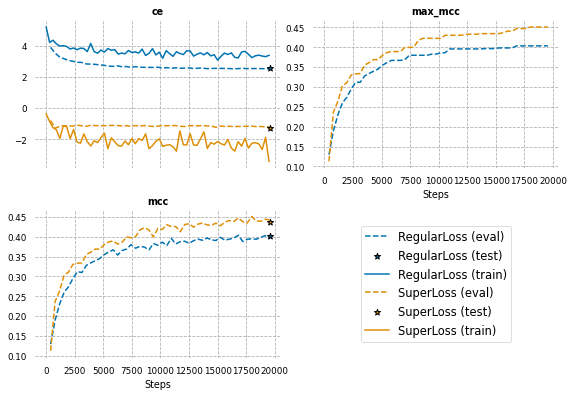

In [9]:
fe.summary.logs.visualize_logs([regular, superL], include_metrics={'mcc', 'ce', 'max_mcc'})

As we can see from the results above, a simple 1 line change to add SuperLoss into the training procedure can raise our model's mcc by a full 4 or 5 points in the presence of noisy input labels. Let's also take a look at the confidence scores generated by SuperLoss on the noisy vs clean data:

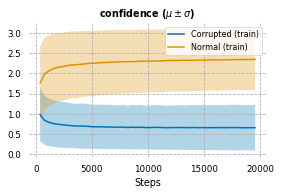

In [10]:
fe.summary.logs.visualize_logs(estimator_super.system.custom_graphs['label_confidence'])

As the graph above demonstrates, the corrupted samples have significantly lower average confidence scores than the clean samples. This is also true when we analyze the confidence scores during regular training, but the separation is not as strong:

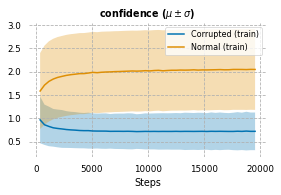

In [11]:
fe.summary.logs.visualize_logs(estimator_regular.system.custom_graphs['label_confidence'])